In [1]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community

Note: you may need to restart the kernel to use updated packages.


In [7]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass()

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

 ········


In [8]:
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass()

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

 ········


In [9]:
!pip install -qU langchain-chroma

## Initialize vectorDB

In [10]:
from langchain_chroma import Chroma

vector_store = Chroma(embedding_function=embeddings)

## Loading docs

In [33]:
from langchain_community.document_loaders.csv_loader import CSVLoader

DATA_DIR = "../../data/"

loader = CSVLoader(file_path=f"{DATA_DIR}faq_final.csv",
                  source_column="id",
                  metadata_columns=["context", "answer"],
                  content_columns=["answer"],
                  csv_args={
                        "fieldnames": ["id", "context", "question", "answer"],
                        }
                  )

docs = loader.load()[1:]
print(docs[0])

page_content='answer: Цалингийн зээлийг сүүлийн 6 сар ажил эрхэлсэн, үндсэн ажилтнаар ажиллаж буй гэрээт байгууллагын ажилтанд олгоно. Одоо ажиллаж буй байгууллагадаа шилжин ажиллахдаа үндсэн ажилтнаар орсон бол цалингийн зээл авч болно.' metadata={'source': 'faq_10_0', 'row': 1, 'context': 'Цалингийн зээл', 'answer': 'Цалингийн зээлийг сүүлийн 6 сар ажил эрхэлсэн, үндсэн ажилтнаар ажиллаж буй гэрээт байгууллагын ажилтанд олгоно. Одоо ажиллаж буй байгууллагадаа шилжин ажиллахдаа үндсэн ажилтнаар орсон бол цалингийн зээл авч болно.'}


In [6]:
print(docs[0].page_content[:500])

None: answer


## Splitting docs

In [13]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


## Storing docs

In [14]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['d316ac81-d795-403b-af30-d582c3c1efb5', '20be1c13-4ac1-4831-b102-a24f9be2a9cc', 'e708fcc0-ba9a-409f-a3c4-0826eeb2bc97']


## Retrieval and generation

In [47]:
from langchain import hub
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# prompt = hub.pull("rlm/rag-prompt")

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "human",
            """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise. Your answer should always be in Mongolian 
            Question: {question} 
            Context: {context} 
            Answer:""",
        ),
    ]
)
example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here),"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise. Your answer should always be in Mongolian 
            Question: (question goes here), 
            Context: (context goes here) 
            Answer:


### State:

In [41]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


In [26]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [27]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

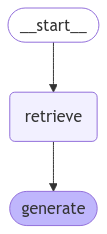

In [28]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [49]:
# result = graph.invoke({"question": "What is Task Decomposition?"}, )
result = graph.invoke({"question": "Санах ойн төрлүүд"}, )

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 5930}, page_content='Fig. 4. Experiments on AlfWorld Env and HotpotQA. Hallucination is a more common failure than inefficient planning in AlfWorld. (Image source: Shinn & Labash, 2023)'), Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 6095}, page_content='Chain of Hindsight (CoH; Liu et al. 2023) encourages the model to improve on its own outputs by explicitly presenting it with a sequence of past outputs, each annotated with feedback. Human feedback data is a collection of $D_h = \\{(x, y_i , r_i , z_i)\\}_{i=1}^n$, where $x$ is the prompt, each $y_i$ is a model completion, $r_i$ is the human rating of $y_i$, and $z_i$ is the corresponding human-provided hindsight feedback. Assume the feedback tuples are ranked by reward, $r_n \\geq r_{n-1} \\geq \\dots \\geq r_1$ The process is supervised fine-tuning where the data is a se